In [88]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [89]:
# 1. Import data
file_path = './data/merged_data.csv'
data = pd.read_csv(file_path)

In [90]:
# # Data Cleaning
# 
# # Remove dollar signs and convert to float for specified columns
# columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']
# for column in columns_to_convert:
#     data[column] = data[column].str.replace('$', '').str.replace(',', '').astype(float)

In [91]:
# Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date', ascending=True)

train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
# train_set = data[(data['Date'] >= '2020-03-24') & (data['Date'] < '2022-06-24')].copy()
valid_set = data[(data['Date'] >= '2022-06-25') & (data['Date'] <= '2024-06-21')].copy()

# # Split data
# total_length = len(data)
# train_length = int(total_length * 0.70)
# train_set = data.iloc[:train_length].copy()
# valid_set = data.iloc[train_length:].copy()


In [92]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one

In [93]:
# 3. Data pre-processing
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close/Last' column for both training and validation sets
train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))
valid_data = scaler.transform(valid_set['Close/Last'].values.reshape(-1, 1))

# Initialize lists to store training and validation data
x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[i-time_steps:i, 0])
    y_valid.append(valid_data[i, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))


In [94]:
# 4. Build Model - function
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# def build_model():
#     model = Sequential()
#     model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units = 50, return_sequences = True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, input_shape=(64,32,16), return_sequences=False))
#     model.add(Dropout(0.2))
#     #model.add(LSTM(units = 50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='linear'))
#     model.add(Dense(units = 1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


In [95]:
# 5. Training - Function
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)


In [96]:
# 6. Make Prediction - Function
def make_prediction(model, x_valid, scaler):
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scaler.inverse_transform(predicted_y_valid_normalized)
    return predicted_y_valid

In [97]:
# Execute step 4,5,6
model = build_model()
train_model(model, x_train, y_train)
predicted_y_valid = make_prediction(model, x_valid, scaler)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0042
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7360e-04
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.9132e-04
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3891e-04
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.0307e-04
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6111e-04
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.5637e-04
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4732e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.2884e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.8676e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4686e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.9967e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.8394e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.1236e-04
Epoch 15/25
69/69 ━━━━━━━━━━━━

LSTM RMSE on validation set: 105.19389441050129


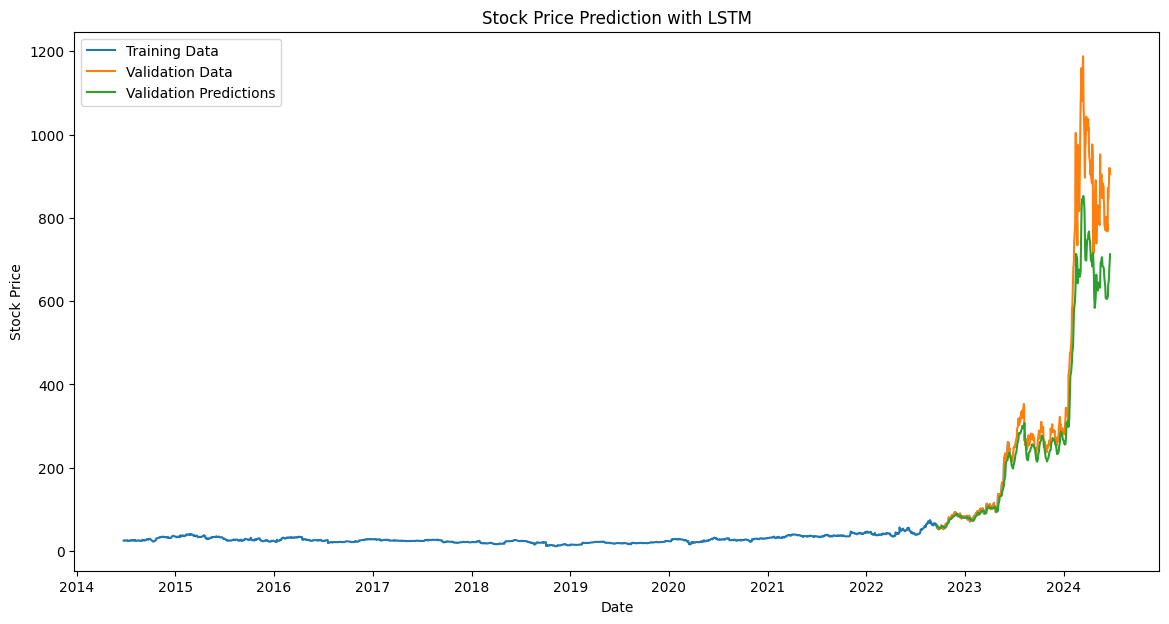

In [98]:
# 7. Print & Visualize the results
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], predicted_y_valid, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()